![](https://i.imgur.com/OX1ADxu.png)

# Introduction

In this notebook, we'll use a classical Machine learning like Decision Tree and a neural Network method like CNN's to classify spoken words from the Audio MNIST dataset. The dataset contains 3000 audio files, where a human pronounces one of ten digits (0-9).

Key takeaways from this notebook:

* We convert 3000 MNIST audio files to spectograms.
* We use Tensorflow's API to create a CNN with multiple 2D convolution layers.
* The network prove excellent at classifying the spectograms in 10 distinct classes. 
* Final validation accuracy is about 98%.

First load the data, then print example files and then plot WAV files.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import wave
import pylab
import IPython
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
from skimage.transform import resize
from skimage.io import imread




In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Set paths to input and output data
INPUT_DIR = '/content/gdrive/MyDrive/Assignment 3 Data Science/archive/free-spoken-digit-dataset-master/recordings/'
OUTPUT_DIR = '/content/gdrive/MyDrive/Assignment 3 Data Science/WORK/'

# Print names of 10 WAV files from the input path
parent_list = os.listdir(INPUT_DIR)
for i in range(10):
    print(parent_list[i])

2_nicolas_11.wav
7_george_10.wav
6_george_15.wav
5_jackson_24.wav
5_nicolas_7.wav
7_jackson_12.wav
5_yweweler_27.wav
2_theo_7.wav
3_lucas_35.wav
3_yweweler_24.wav


You can clearly see the difference in the energy distribution when different words are being pronounced. These distinct characteristics also show up in the spectograms of the recordings, which will enable us transform what was originally an audio problem to an image problem.

In [4]:
audio_file_name  = "5_yweweler_11.wav"
audio_file = wave.open(INPUT_DIR + audio_file_name, mode="r")
sampling_frequency = audio_file.getframerate()
audio_signal = np.frombuffer(audio_file.readframes(audio_file.getframerate()), dtype=np.int16)
audio_file.close()

In [5]:
IPython.display.Audio(INPUT_DIR + audio_file_name)

In [6]:
def plot_four_audio_files_data(wav_file_names_list):
    plt.figure(figsize=(15,5))
    for i, audio_file_name in enumerate(wav_file_names_list):
        audio_file = wave.open(INPUT_DIR + audio_file_name, mode ="r")
        audio_signal = np.frombuffer(audio_file.readframes(audio_file.getframerate()), dtype=np.int16)
        audio_file.close()
        signal_plot = plt.subplot(2, 4, 1 + i)
        signal_plot.plot(audio_signal, color="c")
        spect_plot = plt.subplot(2, 4, 1 + i + 4)
        spect_plot.specgram(audio_signal,Fs=sampling_frequency,cmap = "plasma")
        IPython.display.display(IPython.display.Audio(INPUT_DIR + audio_file_name))

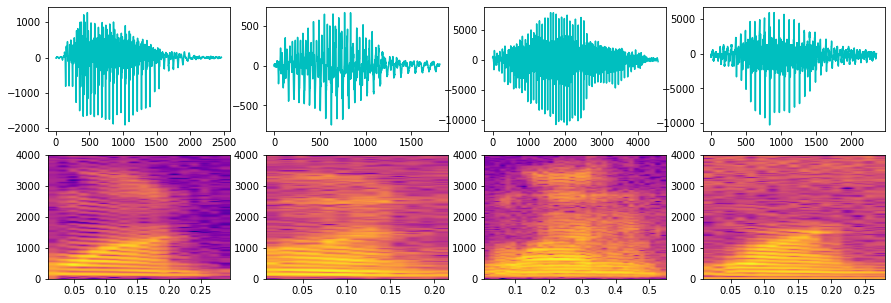

In [7]:
examples_of_wav_files = ["1_yweweler_44.wav","1_theo_15.wav", "1_jackson_5.wav", "1_nicolas_4.wav"]
plot_four_audio_files_data(examples_of_wav_files)

# Convert audio files to spectograms

We can now do the actual conversion of every audio sample. The code below uses the wave and pylab library to extract sound information and frame rate from each sample and save the result as a spectrogram. After this we've simply converted our audio problem to a image problem.

In [ ]:
# Utility function to get sound and frame rate info
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate

# For every recording, make a spectogram and save it as label_speaker_no.png
if not os.path.exists(os.path.join(OUTPUT_DIR, 'audio-images')):
    os.mkdir(os.path.join(OUTPUT_DIR, 'audio-images'))
    
for filename in os.listdir(INPUT_DIR):
    if "wav" in filename:
        file_path = os.path.join(INPUT_DIR, filename)
        file_stem = Path(file_path).stem
        target_dir = f'class_{file_stem[0]}'
        dist_dir = os.path.join(os.path.join(OUTPUT_DIR, 'audio-images'), target_dir)
        file_dist_path = os.path.join(dist_dir, file_stem)
        if not os.path.exists(file_dist_path + '.png'):
            if not os.path.exists(dist_dir):
                os.mkdir(dist_dir)
            file_stem = Path(file_path).stem
            sound_info, frame_rate = get_wav_info(file_path)
            pylab.specgram(sound_info, Fs=frame_rate)
            pylab.savefig(f'{file_dist_path}.png')
            pylab.close()

# Print the ten classes in our dataset
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images'))
print("Classes: \n")
for i in range(10):
    print(path_list[i])
    
# File names for class 1
path_list = os.listdir(os.path.join(OUTPUT_DIR, 'audio-images/class_1'))
print("\nA few example files: \n")
for i in range(10):
    print(path_list[i])

Classes: 

class_2
class_7
class_6
class_5
class_3
class_8
class_4
class_9
class_0
class_1

A few example files: 

1_jackson_3.png
1_george_22.png
1_yweweler_11.png
1_nicolas_12.png
1_theo_23.png
1_george_28.png
1_theo_48.png
1_jackson_22.png
1_lucas_32.png
1_lucas_42.png


In [6]:
Categories=['class_0','class_1','class_2','class_3','class_4','class_5','class_6','class_7','class_8','class_9']
flat_data_arr=[] #input array
target_arr=[] #output array
datadir='/content/gdrive/MyDrive/Assignment 3 Data Science/WORK/audio-images' 
#path which contains all the categories of images
for i in Categories:
    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(150,150,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target
x=df.iloc[:,:-1] #input data 
y=df.iloc[:,-1] #output data

loading... category : class_0
loaded category:class_0 successfully
loading... category : class_1
loaded category:class_1 successfully
loading... category : class_2
loaded category:class_2 successfully
loading... category : class_3
loaded category:class_3 successfully
loading... category : class_4
loaded category:class_4 successfully
loading... category : class_5
loaded category:class_5 successfully
loading... category : class_6
loaded category:class_6 successfully
loading... category : class_7
loaded category:class_7 successfully
loading... category : class_8
loaded category:class_8 successfully
loading... category : class_9
loaded category:class_9 successfully


In [16]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,67461,67462,67463,67464,67465,67466,67467,67468,67469,67470,67471,67472,67473,67474,67475,67476,67477,67478,67479,67480,67481,67482,67483,67484,67485,67486,67487,67488,67489,67490,67491,67492,67493,67494,67495,67496,67497,67498,67499,Target
0,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0
1,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0
2,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0
3,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0
4,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,...,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0.996078,0


In [7]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=42,stratify=y)
print('Splitted Successfully')

Splitted Successfully


In [10]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=8, min_samples_split=10, min_samples_leaf=10)
decision_tree = decision_tree.fit(x_train, y_train)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

#params = {
 #   'max_depth': [2, 3, 5, 10, 20],
  #  'min_samples_leaf': [5, 10, 20, 50, 100],
   # 'criterion': ["gini", "entropy"]
#}

#grid_search = GridSearchCV(estimator=dt, 
 #                          param_grid=params, 
  #                         cv=4, n_jobs=-1, verbose=1, scoring = "accuracy")

model2 = GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100]},
             scoring='accuracy', verbose=1)
model2.fit(x_train,y_train)
print('The Model is trained well with the given images')


#decision_tree = DecisionTreeClassifier(random_state=0, max_depth=2, min_samples_split=20, min_samples_leaf=20)
#decision_tree = decision_tree.fit(iris.data, iris.target)
#model2 = 

Fitting 4 folds for each of 50 candidates, totalling 200 fits


In [11]:
from sklearn.metrics import accuracy_score
y_pred=decision_tree.predict(x_test)
print("The predicted Data is :")
print(y_pred)
print("The actual data is:")
print(np.array(y_test))
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The predicted Data is :
[5 1 6 6 9 7 8 7 3 8 0 8 8 5 5 7 0 9 6 6 8 4 6 1 9 9 3 1 5 7 4 2 6 6 9 7 3
 3 6 6 8 7 6 1 6 5 3 3 4 9 8 0 4 9 4 6 2 1 7 7 4 0 5 1 1 2 9 6 6 1 7 5 0 2
 7 4 6 9 2 8 1 0 9 4 6 6 4 1 6 6 3 2 7 4 8 6 1 3 6 9 8 6 0 3 0 0 8 3 8 2 6
 8 1 0 8 3 3 8 5 9 9 7 2 9 5 2 5 2 7 4 2 5 3 8 1 8 4 1 6 0 5 2 5 5 8 5 2 1
 5 9 3 9 0 7 7 5 4 0 1 6 6 9 0 0 1 1 2 7 3 0 4 7 6 6 7 6 5 6 0 9 6 7 6 4 1
 4 9 5 2 9 1 2 2 8 1 1 5 0 1 9 5 4 8 5 5 1 2 1 6 3 4 3 7 0 5 2 8 2 3 7 5 2
 2 3 3 6 4 7 4 3 4 9 7 8 7 6 0 1 9 6 6 9 8 5 5 0 2 2 7 2 8 2 5 4 0 7 5 1 5
 2 1 4 5 0 3 1 3 2 2 1 0 0 6 5 0 2 3 6 0 9 9 2 6 3 6 7 4 6 4 5 0 4 8 7 3 6
 4 4 3 5 9 3 5 1 7 1 6 4 4 4 8 6 0 4 1 5 5 2 0 0 9 0 7 3 7 1 2 5 3 0 1 7 6
 2 2 6 4 0 2 6 8 3 6 2 3 7 2 7 2 7 1 2 6 0 9 9 1 0 7 5 3 0 6 0 9 7 4 0 6 8
 8 8 4 0 0 2 4 6 7 0 2 5 9 1 2 9 1 8 2 9 0 8 6 4 5 0 0 9 7 4 0 6 6 9 9 0 8
 4 6 1 6 4 2 1 8 4 0 3 7 5 3 6 5 2 9 8 9 2 9 4 3 0 1 4 4 7 6 3 9 7 0 5 8 3
 3 8 8 5 8 8 5 0 0 9 5 2 1 1 8 5 7 5 0 4 5 4 0 3 2 2 6 9 3 8 3 8 5 6 8 7 8
 

Enter URL of Image :/content/gdrive/MyDrive/Assignment 3 Data Science/WORK/audio-images/class_4/4_george_13.png


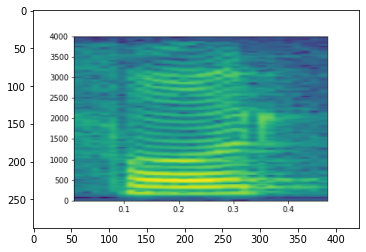

class_0 = 0.0%
class_1 = 0.0%
class_2 = 0.0%
class_3 = 10.0%
class_4 = 80.0%
class_5 = 0.0%
class_6 = 10.0%
class_7 = 0.0%
class_8 = 0.0%
class_9 = 0.0%
The predicted image is : class_4


In [19]:
url=input('Enter URL of Image :')
img=imread(url)
plt.imshow(img)
plt.show()
img_resize=resize(img,(150,150,3))
l=[img_resize.flatten()]
#probability=model.predict_proba(l)
probability=decision_tree.predict_proba(l)
for ind,val in enumerate(Categories):
  print(f'{val} = {probability[0][ind]*100}%')
print("The predicted image is : "+Categories[decision_tree.predict(l)[0]])

# Preparing the data

We can now load the spectrograms into memory. We use the image_dataset_from_directory utility to generate the datasets, and we use Keras image preprocessing layers for image standardization and data augmentation. The validation set is what will ultimately be our benchmark when becomes to performance and accuracy of our classifier. The batch size is set fairly low for now (32) for all images to fit in memory. The seed is for reproducibility.



In [10]:
# Declare constants
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150
BATCH_SIZE = 32
N_CHANNELS = 3
N_CLASSES = 10

# Make a dataset containing the training spectrograms
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="training",
                                             seed=0)

# Make a dataset containing the validation spectrogram
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
                                             batch_size=BATCH_SIZE,
                                             validation_split=0.2,
                                             directory=os.path.join(OUTPUT_DIR, 'audio-images'),
                                             shuffle=True,
                                             color_mode='rgb',
                                             image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
                                             subset="validation",
                                             seed=0)

Found 3004 files belonging to 10 classes.
Using 2404 files for training.
Found 3004 files belonging to 10 classes.
Using 600 files for validation.


Let's quickly visualize a few of the generated spectograms and their labels.

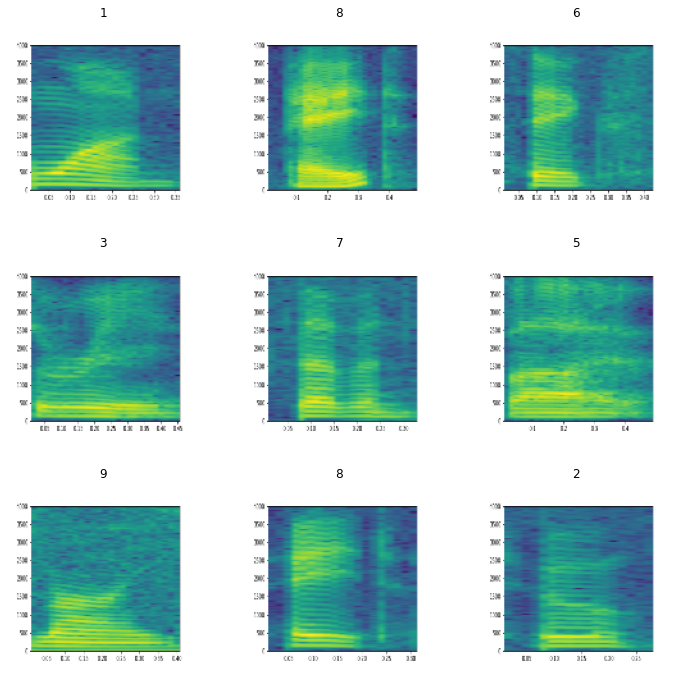

In [11]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

Before we can build our model and start training, we need to apply one simple augmentation the dataset and that is rescaling. We rescale an input in the (0, 255) range to be in the (0,1) range.

In [12]:
# Function to prepare our datasets for modelling
def prepare(ds, augment=False):
    # Define our one transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])
    
    # Apply rescale to both datasets and augmentation only to training
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(valid_dataset, augment=False)

# Modelling



After 10 epochs, the training accuracy reaches 99% and validation accuracy reaches 98%.

In [13]:
model1 = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Print the model summary
model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)     

In [14]:
# Set the training parameters
model1.compile(loss = 'sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Train the model
history1 = model1.fit(train_dataset, epochs=15, validation_data = valid_dataset)

# Save the model
model1.save("rps2.h5")

Epoch 1/15
76/76 [==============================] - 131s 2s/step - loss: 2.1501 - accuracy: 0.2192 - val_loss: 1.5608 - val_accuracy: 0.3883
Epoch 2/15
76/76 [==============================] - 135s 2s/step - loss: 0.7085 - accuracy: 0.7608 - val_loss: 1.8332 - val_accuracy: 0.4233
Epoch 3/15
76/76 [==============================] - 132s 2s/step - loss: 0.3291 - accuracy: 0.8914 - val_loss: 0.2876 - val_accuracy: 0.9183
Epoch 4/15
76/76 [==============================] - 129s 2s/step - loss: 0.1876 - accuracy: 0.9343 - val_loss: 0.1356 - val_accuracy: 0.9650
Epoch 5/15
76/76 [==============================] - 127s 2s/step - loss: 0.1453 - accuracy: 0.9526 - val_loss: 0.7941 - val_accuracy: 0.6983
Epoch 6/15
76/76 [==============================] - 138s 2s/step - loss: 0.1103 - accuracy: 0.9621 - val_loss: 0.1276 - val_accuracy: 0.9767
Epoch 7/15
76/76 [==============================] - 127s 2s/step - loss: 0.0777 - accuracy: 0.9767 - val_loss: 0.1707 - val_accuracy: 0.9650
Epoch 8/15
76

# Evaluation

To evaluate our CNN, we'll look at the loss and accuracy scores to see how well training's progressed and check if there's any underfit/overfit. Evaluations are based on both the training and the validation set. 

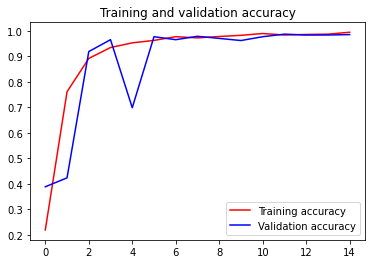

<Figure size 432x288 with 0 Axes>

In [16]:
# Plot the accuracy curves for training and validation.
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

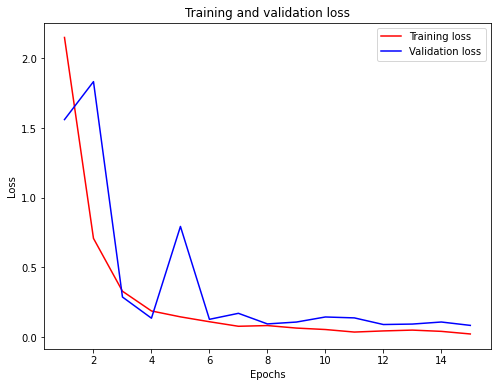

In [17]:
# Plot the loss curves for training and validation.
history_dict = history1.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'red', label='Training loss')
plt.plot(epochs, val_loss_values, 'blue', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

We can compute the final loss and accuracy score on our valid dataset using the evaluate() function.

In [18]:
# Compute the final loss and accuracy
final_loss, final_acc = model1.evaluate(valid_dataset, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.084064, final accuracy: 0.985000


We load our model in order to do our prediction. So we are not oblige to train the model again

In [20]:
from keras.models import load_model
# load the model we saved
model1 = load_model('/content/rps2.h5')

In [30]:
img = tf.keras.preprocessing.image.load_img("/content/gdrive/MyDrive/Assignment 3 Data Science/WORK/audio-images/class_7/7_george_13.png", target_size=(150, 150))
img_array = tf.keras.preprocessing.image.img_to_array(img)
print(img_array.shape)
img_array = tf.expand_dims(img_array, 0)
print(img_array.shape)
predictions = model1.predict(img_array)
score = tf.nn.softmax(predictions[0])
print( "The predicted Digit is: "+ str(np.argmax(score)) )

(150, 150, 3)
(1, 150, 150, 3)
The predicted Digit is: 7


Conversion of the mp3 audio into wav audio

In [15]:
!pip install pydub
from os import path
from pydub import AudioSegment

# files                                                                         
src = "/content/gdrive/MyDrive/Assignment 3 Data Science/test/2.mp3"
dst = "/content/gdrive/MyDrive/Assignment 3 Data Science/test/2.wav"

# convert wav to mp3                                                            
sound = AudioSegment.from_mp3(src)
sound.export(dst, format="wav")

<_io.BufferedRandom name='/content/gdrive/MyDrive/Assignment 3 Data Science/test/2.wav'>

Let's import our audio

In [28]:
IPython.display.Audio('/content/gdrive/MyDrive/Assignment 3 Data Science/test/1.wav')

Conversion of the audio into Spectogram

In [25]:
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.frombuffer(frames, 'int16')
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
#sound_info, frame_rate = get_wav_info("/content/gdrive/MyDrive/Assignment 3 Data Science/test/1.wav")
sound_info, frame_rate = get_wav_info("/content/gdrive/MyDrive/Assignment 3 Data Science/test/2.wav")
pylab.specgram(sound_info, Fs=frame_rate)
#pylab.savefig('/content/gdrive/MyDrive/Assignment 3 Data Science/test/1.png')
pylab.savefig('/content/gdrive/MyDrive/Assignment 3 Data Science/test/2.png')
pylab.close()

/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Prediction of the audio

In [22]:
img = tf.keras.preprocessing.image.load_img("/content/gdrive/MyDrive/Assignment 3 Data Science/test/1.png", target_size=(150, 150))
img_array = tf.keras.preprocessing.image.img_to_array(img)
print(img_array.shape)
img_array = tf.expand_dims(img_array, 0)
print(img_array.shape)
predictions = model1.predict(img_array)
score = tf.nn.softmax(predictions[0])
print( "Digit : "+ str(np.argmax(score)) )


(150, 150, 3)
(1, 150, 150, 3)
Digit : 1
